In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import torch
import numpy as np
import tifffile as tiff
import cv2

from src.LRP import LayerWiseRelevancePropagation
from src.vit_mae_4_hash_lrp import vit_base
import matplotlib.pyplot as plt


In [2]:
# TODO 
# path_to_tifs = ''
# path_to_annot_json = ''
path_to_tifs = "/mnt/storagecube/data/shared/datasets/VesselDetection/v3/vessel_detection_dataset_v3/tif"
path_to_annot_json = "/mnt/storagecube/data/shared/datasets/VesselDetection/v3/vessel_detection_dataset_v3"


In [3]:
# TODO set dev to your preferred device, e.g.
# dev = 'cuda:0'
dev = 'cpu'

In [4]:
kwargs = {'img_size': 128, 'in_chans': 4, 'patch_size': 8}
backbone = vit_base(**kwargs)

In [5]:
ckpt_path = "./weights/weights_lrp.ckpt"

# load ckpt weights into backbone
state = torch.load(ckpt_path, map_location="cpu")["state_dict"]
ret = backbone.load_state_dict(state, strict=False)
print('Loading:', ret)


Loading: <All keys matched successfully>


In [6]:
with open(f'{path_to_annot_json}/vessels_dataset_annotations.json') as f:
    d = json.load(f)
    annotations_dict = d


def patch_name_2_img(patch_name):
    """Receive a file name (without '.tif') and return then corresponding image.

    Args:
        patch_name (str): tif file name

    Returns:
        numpy: img, img as rgb, list of coordinates
    """
    
    path_tif = f'{path_to_tifs}/{patch_name}.tif'

    img = tiff.imread(path_tif)
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    img = np.flipud(img)
    img3 = img[:,:,[0,1,2]]

    geo_list = annotations_dict[patch_name]['annotations']

    coords_list = []
    for geo in geo_list:
        coord = geo['geometry']['coordinates'][0]
        coord.append(coord[0])
        coords_list.append(list(zip(*coord)))

    return img, img3, coords_list


img_samples = [
    'T32TLP_20190803T103029_TCI_crop_x-1536_y-5760', 
]

In [7]:
def add_mask_to_img(img, mask):
    """Add a relevance mask to the image

    Args:
        img (numpy): img of shape HxWx3
        mask (numpy): mask of shape HxW

    Returns:
        numpy: combination of both images, shape HxWx3
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    
    cam =  np.uint8(255 * cam)
    cam = cv2.cvtColor(np.array(cam), cv2.COLOR_RGB2BGR)
    
    return cam

def generate_lrp_mask(lrp, original_image, class_indices):
    """Generate a relevance mask for the given input image.

    Args:
        lrp: LayerwiseRelevancePropoagation
        original_image (torch.Tensor): img
        class_indices (List[int]): List of indices from { 0, 1, 2 } where 0 is no vessel and 1,2 are vessel

    Returns:
        numpy: mask of shape HxW
    """
    
    r_list = []
    
    for class_index in class_indices:
        r = lrp.run_relprop(original_image.unsqueeze(0).to(dev), method="transformer_attribution", index=class_index).detach()
        r = r.reshape(1, 1, 16, 16)
        r = torch.nn.functional.interpolate(r, scale_factor=8, mode='bilinear')
        r = r.reshape(128, 128).data.cpu().numpy()
        r = (r - r.min()) / (r.max() - r.min())

        r_list.append(r)

    r = np.mean(r_list, axis=0)
    return r

In [8]:
# leave them as constants
NUM_TOKENS = 257
BATCH_SIZE = 1
EYE = (
    torch.eye(NUM_TOKENS)
    .expand(BATCH_SIZE, NUM_TOKENS, NUM_TOKENS)
    .to(dev)
)

lrp = LayerWiseRelevancePropagation(backbone, EYE, dev)

/tmp/ipykernel_569463/1465433110.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  img_torch = torch.from_numpy(img.copy()).T.to(torch.float)


Probability 'no-vessel': 0.4737
Probability    'vessel': 0.5263


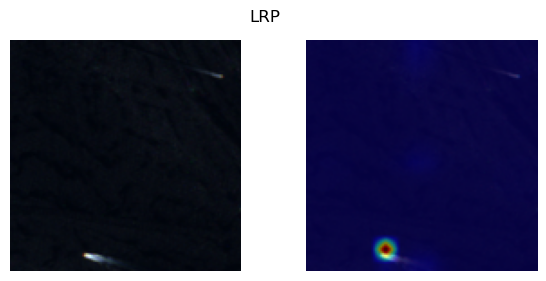

In [9]:
# for given file name, load image
img, img_rgb, img_coords = patch_name_2_img(img_samples[0])
img_rgb = np.transpose(img_rgb, (1,0,2)) # rotation to match orientation in torch tensors after calling '.T'

# move numpy image to torch and convert to format NCHW
img_torch = torch.from_numpy(img.copy()).T.to(torch.float)
img_torch_batched = img_torch.unsqueeze(0).to(dev)

# feed image through model to generate gradients
backbone.to(dev).eval()
logits = backbone(img_torch_batched)

# generate 
no_vessel_mask = generate_lrp_mask(lrp, img_torch, class_indices=[0])
vessel_mask = generate_lrp_mask(lrp, img_torch, class_indices=[1,2])

# stats on the predicition probabilities
probs = torch.nn.functional.softmax(logits, dim=-1).squeeze(0).squeeze(0)
no_vessel_prob = probs[0]
vessel_prob = probs[1] + probs[2]
print(f"Probability 'no-vessel': {no_vessel_prob:.4f}")
print(f"Probability    'vessel': {vessel_prob:.4f}")

# plot and save to file
fig, axs = plt.subplots(1, 2, figsize=(7,3))
for ax in axs.ravel():
    ax.set_axis_off()

axs[0].imshow(img_rgb)
axs[1].imshow(add_mask_to_img(img_rgb, vessel_mask))

fig.suptitle("LRP")
fig.savefig("lrp_example.png")

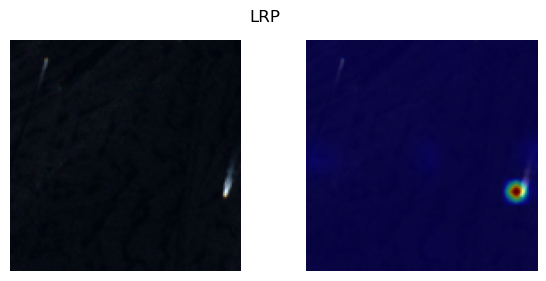

In [10]:
# rotate according to your orientation
num_rotations_90deg = 1

rotated_img_rgb = np.rot90(img_rgb, num_rotations_90deg, (0,1))
rotated_vessel_mask = np.rot90(vessel_mask, num_rotations_90deg, (0,1))

# plot and save to file
fig, axs = plt.subplots(1, 2, figsize=(7,3))
for ax in axs.ravel():
    ax.set_axis_off()

axs[0].imshow(rotated_img_rgb)
axs[1].imshow(add_mask_to_img(rotated_img_rgb, rotated_vessel_mask))

fig.suptitle("LRP")
fig.savefig("lrp_example_rotated.png")
